## **Machine Learning - Clasificación**

---
### **Librerías**

In [33]:
import warnings

warnings.filterwarnings("ignore")  # Suprime warnings

import pandas as pd
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


---
### **1. Cargar dataset y definir `X` e `y`**

In [16]:
# Ruta de los outputs
output_folder = "../../data/outputs/3_eda"

# Cargar el DataFrame preprocesado que incluye el texto concatenado y la variable objetivo
texto_medicamentos_df = pd.read_csv(
    os.path.join(output_folder, "texto_concatenado_medicamentos.csv")
)
print("Columnas:", texto_medicamentos_df.columns.tolist())

# Aseguramos que la variable objetivo esté presente (por ejemplo, "descripcion_nivel_anatomico")
assert (
    "descripcion_nivel_anatomico" in texto_medicamentos_df.columns
), "No se encontró la variable objetivo."

Columnas: ['medicamento', 'descripcion_nivel_anatomico', 'descripcion_nivel_2_subgrupo_terapeutico', 'descripcion_nivel_3_subgrupo_terapeutico_farmacologico', 'descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico', 'descripcion_nivel_5_principio_activo', 'texto_completo']


In [17]:
# Cargar el vectorizador TF-IDF y la matriz vectorizada
with open(os.path.join(output_folder, "tfidf_vectorizer.pkl"), "rb") as f:
    tfidf_vectorizer = pickle.load(f)

with open(os.path.join(output_folder, "tfidf_matrix.pkl"), "rb") as f:
    tfidf_matrix = pickle.load(f)

# Definir features (X) y variable objetivo (y)
X = tfidf_matrix  # Matriz TF-IDF
# Queremos predecir el nivel anatomico, es decir, sistema nervioso, digestivo, etc.
y = texto_medicamentos_df["descripcion_nivel_anatomico"]
# Rellenar valores nulos
y = y.fillna("Desconocido")

# Convertir categorías a valores numéricos
le = LabelEncoder()
y = le.fit_transform(y) # 1,2,3,4,5, ...
# categorias_originales = le.inverse_transform(y) # si queremos revertir la codificación


---
### **2. Devidir en `train` y `test`**

In [18]:
# Dividir en entrenamiento (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

---
### **3. Clasificación del `grupo anatómico` de los medicamentos**

---
### **3.1 Regresión logística (LR)**

---
##### **Entrenamiento**

In [20]:
# --- Regresión Logística ---
print("### Grid Search: Regresión Logística ###")

# Definir el grid de hiperparámetros. Por ejemplo, se puede optimizar el parámetro C
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"],  # Para 'l1' se necesita solver 'liblinear'
    "solver": ["lbfgs"],  # lbfgs soporta multiclass
    "max_iter": [1000],
}

### Grid Search: Regresión Logística ###


In [21]:
lr = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [1000],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring='accuracy')

In [22]:
print("Mejores hiperparámetros (LogReg):", grid_lr.best_params_)
print("Mejor CV Accuracy (LogReg): {:.2f}".format(grid_lr.best_score_))

Mejores hiperparámetros (LogReg): {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor CV Accuracy (LogReg): 0.92


---
##### **Test**

In [23]:
# Evaluación en el conjunto de entrenamiento y test
best_lr = grid_lr.best_estimator_
y_train_pred_lr = best_lr.predict(X_train)
y_test_pred_lr = best_lr.predict(X_test)

print(
    "Regresión Logística - Train Accuracy: {:.2f}".format(
        accuracy_score(y_train, y_train_pred_lr)
    )
)
print(
    "Regresión Logística - Test Accuracy: {:.2f}".format(
        accuracy_score(y_test, y_test_pred_lr)
    )
)
print(
    "\nReporte de Clasificación - Regresión Logística (Test):\n",
    classification_report(y_test, y_test_pred_lr, zero_division=0),
)

Regresión Logística - Train Accuracy: 0.98
Regresión Logística - Test Accuracy: 0.93

Reporte de Clasificación - Regresión Logística (Test):
               precision    recall  f1-score   support

           0       0.82      0.74      0.78       562
           1       0.94      0.98      0.96       215
           2       0.93      0.98      0.95       222
           3       0.89      0.89      0.89        89
           4       0.90      0.97      0.93        58
           5       0.56      0.62      0.59         8
           6       0.92      0.93      0.92       170
           7       0.97      0.99      0.98       710
           8       0.96      0.97      0.96       345
           9       0.93      0.91      0.92       170
          10       0.94      0.93      0.94       142
          11       0.95      0.98      0.96       922
          12       0.94      0.94      0.94       221
          13       0.92      0.92      0.92        73
          14       0.96      0.85      0.90    

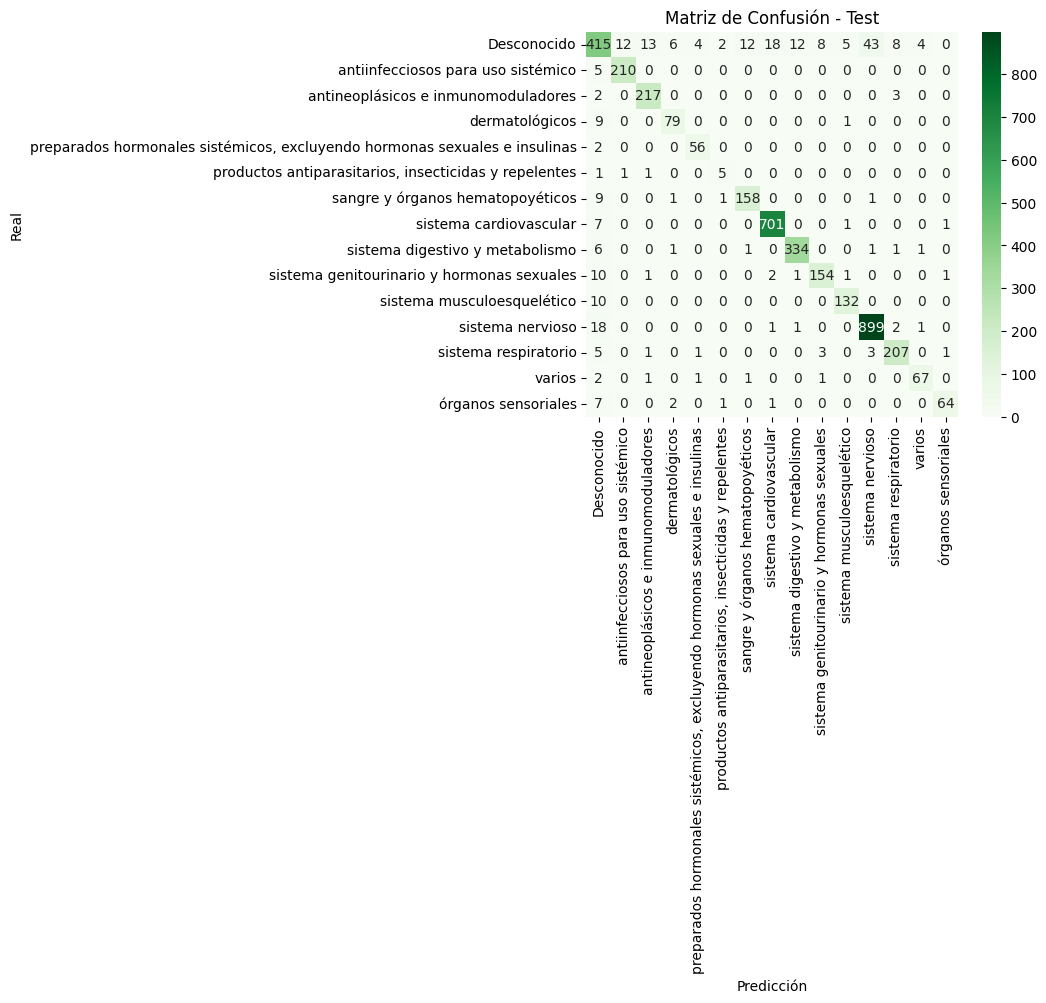

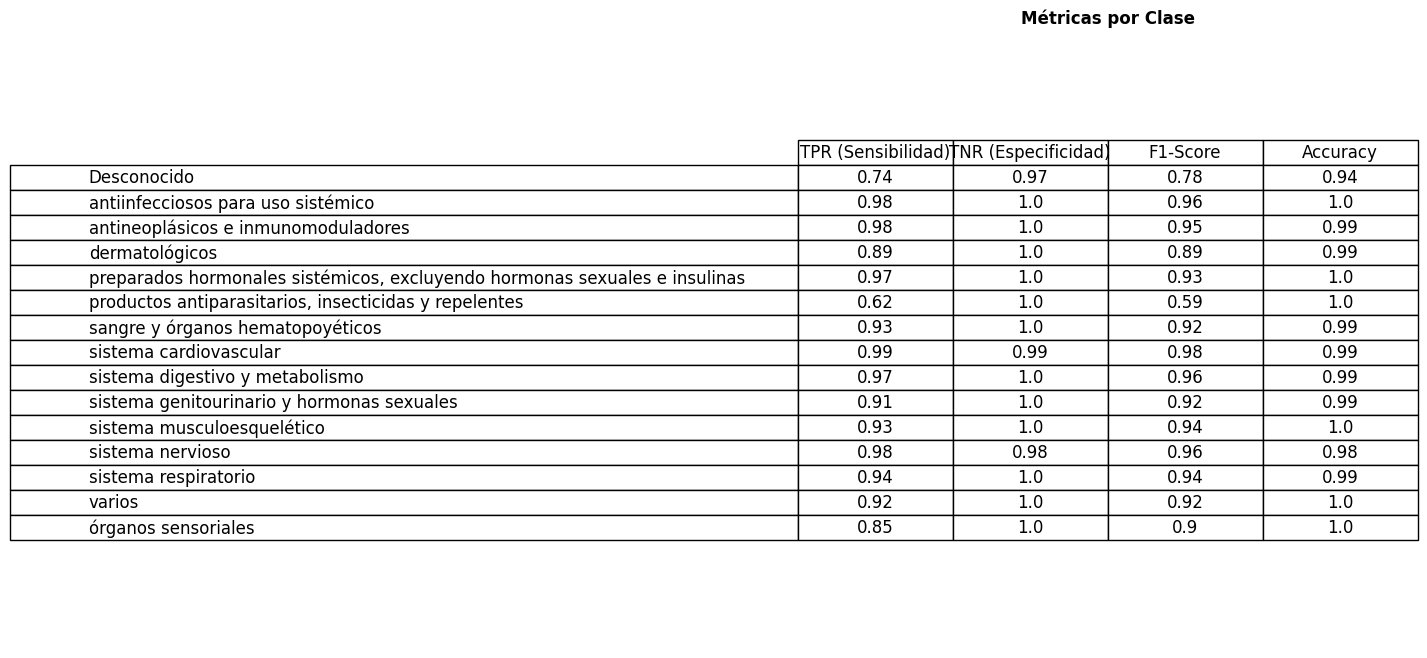

In [38]:
# Función para mostrar la matriz de confusión
def plot_test_confusion_matrix_metrics(y_test, y_pred_test):
    """
    Genera y muestra de forma visual la matriz de confusión para el conjunto de test y, en una figura aparte,
    muestra una tabla con los indicadores TPR (Sensibilidad), TNR (Especificidad), F1-Score y Accuracy para cada clase.
    
    Parámetros:
        y_test (array-like): Etiquetas reales del conjunto de test.
        y_pred_test (array-like): Predicciones del modelo sobre el conjunto de test.
    
    Nota:
        Se asume que la variable global 'le' (LabelEncoder) ha sido definida y entrenada previamente
        para obtener los nombres originales de las clases.
    """

    # Calcular la matriz de confusión para test
    cm = confusion_matrix(y_test, y_pred_test)
    class_names = le.classes_
    n_classes = len(class_names)

    # Mostrar la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión - Test')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

    # Calcular métricas por clase
    metrics = {"Clase": [], "TPR (Sensibilidad)": [], "TNR (Especificidad)": [], "F1-Score": [], "Accuracy": []}
    total = cm.sum()
    for i in range(n_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FN + FP)
        
        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        tnr = TN / (TN + FP) if (TN + FP) > 0 else 0
        f1 = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
        acc = (TP + TN) / total if total > 0 else 0
        
        metrics["Clase"].append(class_names[i])
        metrics["TPR (Sensibilidad)"].append(round(tpr, 2))
        metrics["TNR (Especificidad)"].append(round(tnr, 2))
        metrics["F1-Score"].append(round(f1, 2))
        metrics["Accuracy"].append(round(acc, 2))
    
    df_metrics = pd.DataFrame(metrics).set_index("Clase")
    
    # Visualizar la tabla de métricas
    fig, ax = plt.subplots(figsize=(8, 0.5 + 0.5 * n_classes))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df_metrics.values,
                     colLabels=df_metrics.columns,
                     rowLabels=df_metrics.index,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    plt.title("Métricas por Clase", fontweight="bold")
    plt.tight_layout()
    plt.show()

# Matriz de confusión de la regresión logística
plot_test_confusion_matrix_metrics(y_test, y_test_pred_lr)

---
#### **3.2 Random Forest (RF)**

---
##### **Entrenamiento**

In [24]:
# --- RandomForest ---
print("\n### Grid Search: RandomForestClassifier ###")

param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}


### Grid Search: RandomForestClassifier ###


In [25]:
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [26]:
print("Mejores hiperparámetros (RF):", grid_rf.best_params_)
print("Mejor CV Accuracy (RF): {:.2f}".format(grid_rf.best_score_))

Mejores hiperparámetros (RF): {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Mejor CV Accuracy (RF): 0.94


---
##### **Test**

In [27]:
# Evaluación en el conjunto de entrenamiento y test
best_rf = grid_rf.best_estimator_
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

print(
    "RandomForest - Train Accuracy: {:.2f}".format(
        accuracy_score(y_train, y_train_pred_rf)
    )
)
print(
    "RandomForest - Test Accuracy: {:.2f}".format(
        accuracy_score(y_test, y_test_pred_rf)
    )
)
print(
    "\nReporte de Clasificación - RandomForest (Test):\n",
    classification_report(y_test, y_test_pred_rf, zero_division=0),
)

RandomForest - Train Accuracy: 1.00
RandomForest - Test Accuracy: 0.95

Reporte de Clasificación - RandomForest (Test):
               precision    recall  f1-score   support

           0       0.87      0.81      0.84       562
           1       0.90      0.98      0.94       215
           2       0.96      1.00      0.98       222
           3       0.85      0.93      0.89        89
           4       0.95      0.95      0.95        58
           5       1.00      0.62      0.77         8
           6       0.94      0.95      0.95       170
           7       0.98      0.99      0.99       710
           8       0.97      0.98      0.97       345
           9       0.94      0.91      0.92       170
          10       0.98      0.94      0.96       142
          11       0.96      0.99      0.98       922
          12       0.94      0.92      0.93       221
          13       0.97      0.88      0.92        73
          14       0.99      0.89      0.94        75

    accuracy 

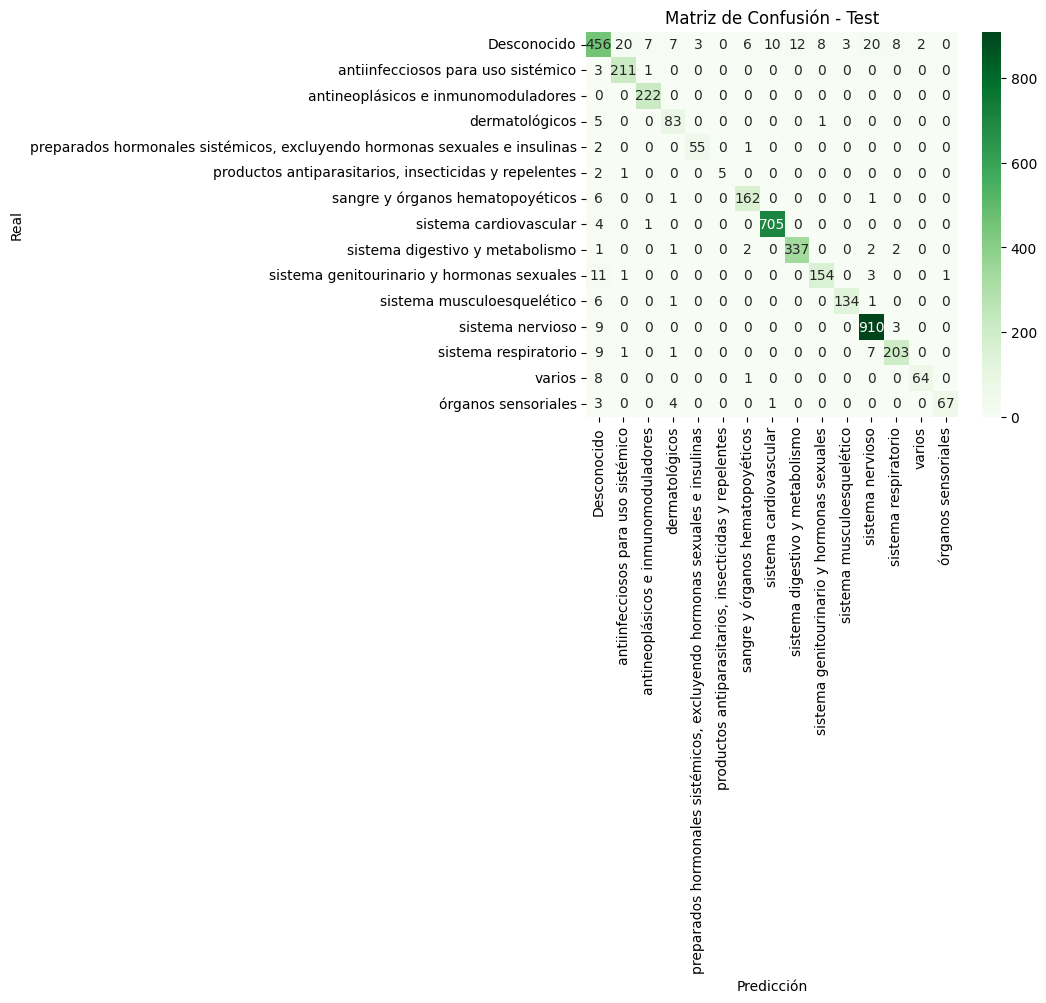

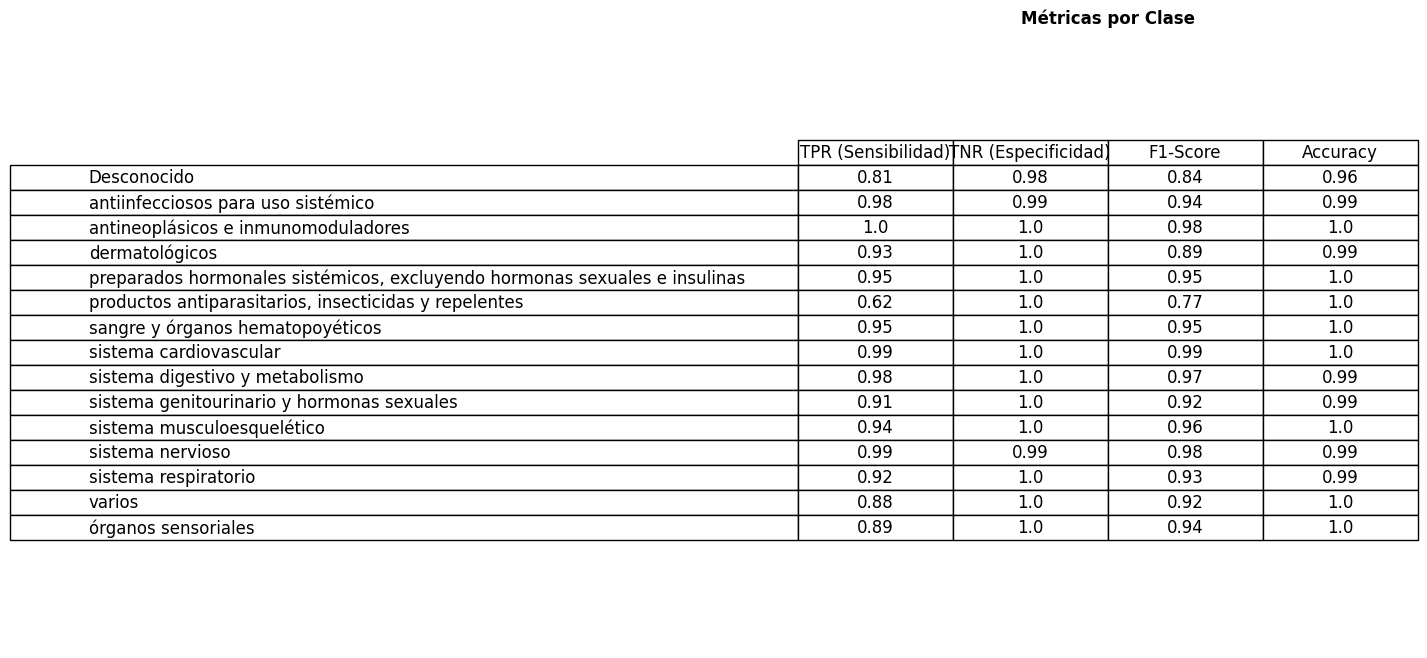

In [39]:
# Matriz de confusión de la random forest
plot_test_confusion_matrix_metrics(y_test, y_test_pred_rf)

---
### **4. Análisis de explicabilidad de los modelos**

In [28]:
############################################
# 2. Interpretabilidad: Variables Explicativas #
############################################

# --- Para Regresión Logística ---
# Extraer coeficientes: best_lr.coef_ tiene forma (n_clases, n_features)
feature_names = tfidf_vectorizer.get_feature_names_out()
coef = best_lr.coef_

# Por ejemplo, para cada clase mostramos las 10 características con coeficiente más alto
print("\nTop características por clase (Regresión Logística):")
for idx, class_label in enumerate(best_lr.classes_):
    coef_class = coef[idx]
    # Ordenar índices de mayor a menor
    top10_idx = np.argsort(coef_class)[-10:]
    top_features = feature_names[top10_idx]
    top_coef = coef_class[top10_idx]
    print(f"\nClase: {class_label}")
    for feat, coef_val in zip(top_features[::-1], top_coef[::-1]):
        print(f"{feat}: {coef_val:.4f}")


# --- Para RandomForest ---
# Extraer feature_importances_
importances = best_rf.feature_importances_
indices_rf = np.argsort(importances)[-10:]
print("\nTop características (RandomForest):")
for idx in indices_rf[::-1]:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Top características por clase (Regresión Logística):

Clase: 0
sanitarios: 31.2761
eu: 26.1087
central: 20.0585
trastornos sistema: 17.3008
citocromo: 16.6987
basal: 14.0434
similares: 13.7959
infecciones: 13.1843
retraso: 12.4372
función: 12.2512

Clase: 1
sistémico: 60.1194
tel: 13.4862
ritonavir: 12.5544
infecciones: 11.5091
concomitante: 10.6099
claritromicina: 10.4435
diarrea: 10.3674
itraconazol: 9.9977
atazanavir: 9.9333
beta: 9.7338

Clase: 2
agentes: 13.5928
leucopenia: 12.2531
neutropenia: 10.5397
fase: 10.3726
plaquetas: 10.1615
células: 9.7616
cáncer: 9.5250
iii: 9.0862
trasplante: 8.4915
plasma: 8.1374

Clase: 3
efecto: 11.4997
piel: 11.0975
información: 10.2006
cutáneas: 10.0756
tratar: 9.3490
evitar: 8.8989
comunicado: 8.2826
realizados: 7.9755
potentes: 7.9376
demostrado: 7.5104

Clase: 4
sistémicos: 11.0709
crecimiento: 10.4330
sérico: 8.5323
hiponatremia: 8.4792
terapia: 7.7418
inicio: 7.6442
trastornos: 7.1697
niveles: 6.8657
microgramos: 6.6175
potasio: 6.3289

Cla

---
### **5. Otras pruebas**

In [29]:
############################################
# 3. Prueba manual de un medicamento       #
############################################


# Seleccionar manualmente un ejemplo del DataFrame (por ejemplo, la primera fila)
manual_sample = texto_medicamentos_df.iloc[0]
sample_text = manual_sample["texto_completo"]

# Transformar el texto a la representación TF-IDF (usando el vectorizador cargado)
sample_vector = tfidf_vectorizer.transform([sample_text])

# Predecir con ambos modelos (y obtener probabilidades)
lr_proba = best_lr.predict_proba(sample_vector)[0]
rf_proba = best_rf.predict_proba(sample_vector)[0]

print("\n--- Predicción manual ---")
print("Medicamento:", manual_sample["medicamento"])
print("Texto (truncado):", sample_text[:200], "...")
print("\nPredicción Regresión Logística:")
for label, prob in zip(best_lr.classes_, lr_proba):
    print(f"{label}: {prob:.2f}")

print("\nPredicción RandomForest:")
for label, prob in zip(best_rf.classes_, rf_proba):
    print(f"{label}: {prob:.2f}")

# También podemos ver la predicción final
print("\nPredicción final (LogReg):", best_lr.predict(sample_vector)[0])
print("Predicción final (RF):", best_rf.predict(sample_vector)[0])


--- Predicción manual ---
Medicamento: A.A.S._100_mg_COMPRIMIDOS
Texto (truncado): en base a su efecto antiagregante plaquetario está indicado en la profilaxis de infarto de miocardio o reinfarto de miocardio en pacientes con angina de pecho inestable y para prevenir la recurrencia  ...

Predicción Regresión Logística:
0: 0.20
1: 0.00
2: 0.00
3: 0.00
4: 0.00
5: 0.00
6: 0.28
7: 0.00
8: 0.00
9: 0.00
10: 0.00
11: 0.52
12: 0.00
13: 0.00
14: 0.00

Predicción RandomForest:
0: 0.16
1: 0.04
2: 0.02
3: 0.01
4: 0.00
5: 0.00
6: 0.09
7: 0.07
8: 0.01
9: 0.02
10: 0.01
11: 0.54
12: 0.01
13: 0.01
14: 0.02

Predicción final (LogReg): 11
Predicción final (RF): 11
